In [1]:
import pandas as pd
from prophet import Prophet
from prophet.diagnostics import cross_validation
import os
import numpy as np 
from matplotlib import pyplot as plt
from to_influx import create_csv_from_influx
from statsmodels.tsa.arima.model import ARIMA

Importing plotly failed. Interactive plots will not work.


# DataFrame cleaning and cuple creation for Gas, Humidity and Temperature

In [2]:
# DataFrame cleaning:
"""
    Removing an influx unnamed column
    Dropping NaN rows
    Replacing label '_time' with 'time'
"""
def adjust_time(time):
    return time.split('.')[0]

def adjust_dataframe(df, inplace):
    dfcopy = df.copy()
    if inplace:
        # Dropping an unnamed column created by influx
        df.drop(df.columns[df.columns.str.contains('unnamed',case = False)],axis = 1, inplace = True)
        # Rename of _time column into time
        df.rename(columns={'_time': 'time'}, inplace=True)
        # Dropping rows which have NaN
        df.dropna(inplace=True)
        # Apply time adjustement
        df['time' ] = df['time'].apply(adjust_time)
    else:
        # Dropping an unnamed column created by influx
        dfcopy.drop(df.columns[df.columns.str.contains('unnamed',case = False)],axis = 1, inplace = True)
        # Rename of _time column into time
        dfcopy.rename(columns={'_time': 'time'}, inplace=True)
        # Dropping rows which have NaN
        dfcopy.dropna(inplace=True)
        # Apply time adjustement
        dfcopy['time'] = dfcopy['time'].apply(adjust_time)
        return dfcopy

def compute_MSE(true, predicted):
    return np.square(np.subtract(true, predicted)).mean()

In [3]:
csv_path = os.path.join(os.getcwd(), "dataset/test_18_07.csv")

df = pd.read_csv(csv_path, header=0)

df_adjusted=adjust_dataframe(df, inplace=False)

In [4]:
df

,Unnamed: 0,_time,AQI,gas,temperature,humidity,wifi
0,117,2022-07-18 15:07:40.790055+00:00,1.0,67.0,30.100000,NaN,-48.0
1,118,2022-07-18 15:08:41.308075+00:00,1.0,201.0,30.100000,33.0,-49.0
2,119,2022-07-18 15:09:41.828956+00:00,1.0,123.0,30.200001,32.0,-48.0
3,120,2022-07-18 15:10:42.270264+00:00,1.0,158.0,30.200001,32.0,-49.0
4,121,2022-07-18 15:11:42.872441+00:00,1.0,179.0,30.299999,32.0,-46.0
...,...,...,...,...,...,...,...
221,338,2022-07-18 18:45:19.548551+00:00,1.0,154.0,31.799999,27.0,-47.0
222,339,2022-07-18 18:46:20.014914+00:00,1.0,142.0,31.799999,28.0,-45.0
223,340,2022-07-18 18:47:20.721355+00:00,1.0,117.0,31.799999,28.0,-46.0
224,341,2022-07-18 18:48:21.163319+00:00,1.0,212.0,31.799999,28.0,-50.0


In [5]:
df_adjusted

,time,AQI,gas,temperature,humidity,wifi
1,2022-07-18 15:08:41,1.0,201.0,30.100000,33.0,-49.0
2,2022-07-18 15:09:41,1.0,123.0,30.200001,32.0,-48.0
3,2022-07-18 15:10:42,1.0,158.0,30.200001,32.0,-49.0
4,2022-07-18 15:11:42,1.0,179.0,30.299999,32.0,-46.0
5,2022-07-18 15:12:43,1.0,157.0,30.200001,32.0,-49.0
...,...,...,...,...,...,...
221,2022-07-18 18:45:19,1.0,154.0,31.799999,27.0,-47.0
222,2022-07-18 18:46:20,1.0,142.0,31.799999,28.0,-45.0
223,2022-07-18 18:47:20,1.0,117.0,31.799999,28.0,-46.0
224,2022-07-18 18:48:21,1.0,212.0,31.799999,28.0,-50.0


In [6]:
# FB PROPHET NEEDS A DATAFRAME MADE OF (TIME, VALUE) THEREFORE WE ARE SPLITTING THE DATAFRAME IN CUPLES

def split_in_cuples(df):
    return df.loc[:,['time','gas']], df.loc[:,['time','humidity']], df.loc[:,['time','temperature']]

gas, humidity, temperature = split_in_cuples(df_adjusted)

## Temperature forecast using FB Prophet

In [7]:
m = Prophet(daily_seasonality=True)
temp_temperature = temperature.copy()
temp_temperature.rename(columns= {'time': 'ds', 'temperature':'y'}, inplace=True)

periods_temperature_prophet = 20

temporary_temperature_train, temporary_temperature_predict = temp_temperature[:-periods_temperature_prophet], temp_temperature[-periods_temperature_prophet:]
temperature_prediction_prophet = pd.DataFrame()
temperature_prediction_prophet['ds'] = temporary_temperature_predict['ds']

m.fit(temporary_temperature_train)
temperature_prediction_prophet = m.predict(temperature_prediction_prophet)


15:27:13 - cmdstanpy - INFO - Chain [1] start processing
15:27:14 - cmdstanpy - INFO - Chain [1] done processing


In [8]:
mse = compute_MSE(temporary_temperature_predict['y'].values, temperature_prediction_prophet['yhat'].values)
mse

0.020046095906068758

#### DataFrame workaround for plottings

In [9]:
temporary_temperature_train['ds'] = pd.to_datetime(temporary_temperature_train['ds'])
temporary_temperature_train = temporary_temperature_train.set_index('ds')

temporary_temperature_predict['ds'] = pd.to_datetime(temporary_temperature_predict['ds'])
temporary_temperature_predict = temporary_temperature_predict.set_index('ds')

temperature_prediction_prophet = temperature_prediction_prophet.set_index('ds')

C:\Users\Marco\AppData\Local\Temp\ipykernel_8576\3995615983.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  temporary_temperature_train['ds'] = pd.to_datetime(temporary_temperature_train['ds'])
C:\Users\Marco\AppData\Local\Temp\ipykernel_8576\3995615983.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  temporary_temperature_predict['ds'] = pd.to_datetime(temporary_temperature_predict['ds'])


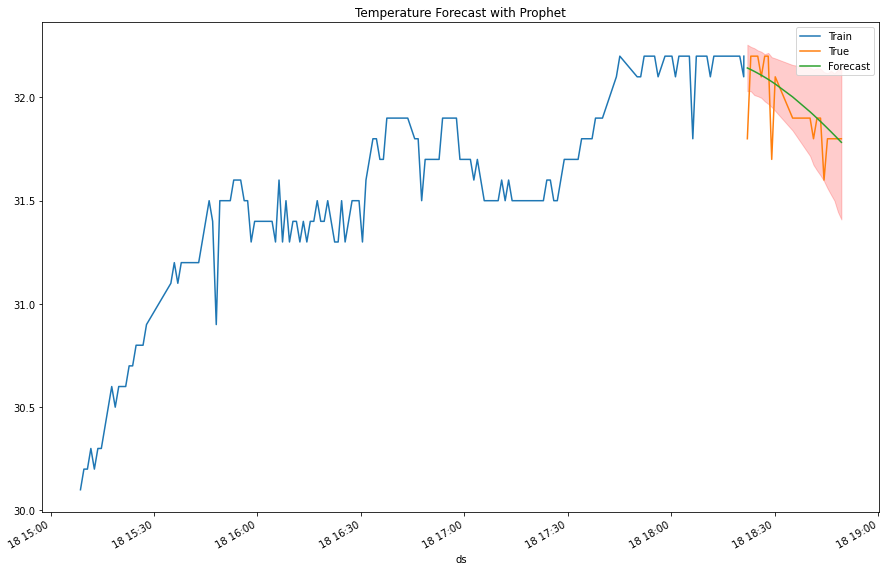

In [10]:
fig, ax = plt.subplots(figsize=(15, 10))
temporary_temperature_train['y'].plot(ax=ax, label='Train')
temporary_temperature_predict['y'].plot(ax=ax, label= 'True')
temperature_prediction_prophet['yhat'].plot(ax=ax, label='Forecast')
ax.fill_between(
    temperature_prediction_prophet.index,
    temperature_prediction_prophet['yhat_lower'],
    temperature_prediction_prophet['yhat_upper'],
    color = 'red',
    alpha = 0.2
)
ax.set_title('Temperature Forecast with Prophet')
ax.legend();

## Humidity forecast using FB Prophet

In [18]:
m = Prophet(daily_seasonality=True)
temp_humidity = humidity.copy()
temp_humidity.rename(columns= {'time': 'ds', 'humidity':'y'}, inplace=True)

periods_humidity_prophet = 10

temporary_humidity_train, temporary_humidity_predict = temp_humidity[:-periods_humidity_prophet], temp_humidity[-periods_humidity_prophet:]
humidity_prediction_prophet = pd.DataFrame()
humidity_prediction_prophet['ds'] = temporary_humidity_predict['ds']

m.fit(temporary_humidity_train)
humidity_prediction_prophet = m.predict(humidity_prediction_prophet)

15:28:09 - cmdstanpy - INFO - Chain [1] start processing
15:28:09 - cmdstanpy - INFO - Chain [1] done processing


In [20]:
mse = compute_MSE(temporary_humidity_predict['y'].values, humidity_prediction_prophet['yhat'].values)
mse

0.7746445138890727

#### DataFrame workaround for plottings

In [19]:
temporary_humidity_train['ds'] = pd.to_datetime(temporary_humidity_train['ds'])
temporary_humidity_train = temporary_humidity_train.set_index('ds')

temporary_humidity_predict['ds'] = pd.to_datetime(temporary_humidity_predict['ds'])
temporary_humidity_predict = temporary_humidity_predict.set_index('ds')

humidity_prediction_prophet = humidity_prediction_prophet.set_index('ds')

C:\Users\Marco\AppData\Local\Temp\ipykernel_8576\3354956532.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  temporary_humidity_train['ds'] = pd.to_datetime(temporary_humidity_train['ds'])
C:\Users\Marco\AppData\Local\Temp\ipykernel_8576\3354956532.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  temporary_humidity_predict['ds'] = pd.to_datetime(temporary_humidity_predict['ds'])


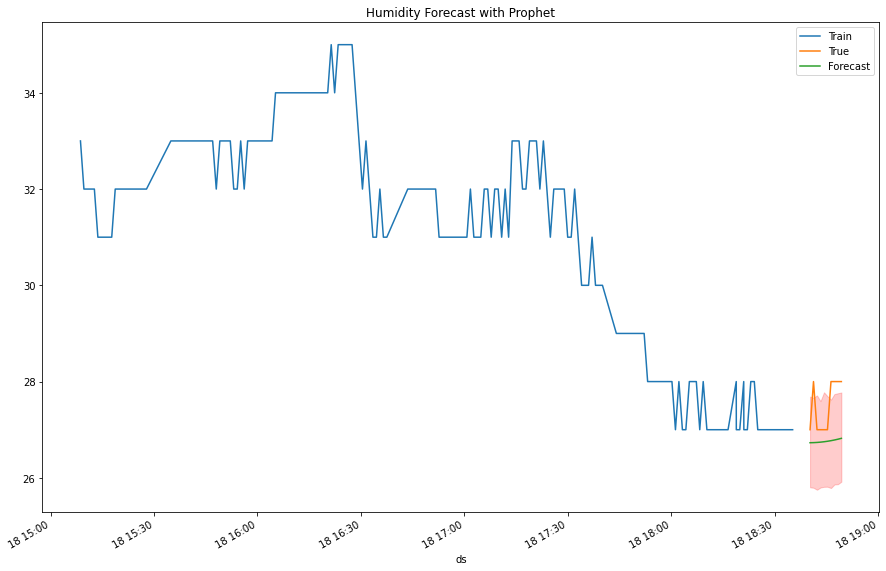

In [21]:
fig, ax = plt.subplots(figsize=(15, 10))
temporary_humidity_train['y'].plot(ax=ax, label='Train')
temporary_humidity_predict['y'].plot(ax=ax, label= 'True')
humidity_prediction_prophet['yhat'].plot(ax=ax, label='Forecast')
ax.fill_between(
    humidity_prediction_prophet.index,
    humidity_prediction_prophet['yhat_lower'],
    humidity_prediction_prophet['yhat_upper'],
    color = 'red',
    alpha = 0.2
)
ax.set_title('Humidity Forecast with Prophet')
ax.legend();

# Gas forecast using FB Prophet

In [24]:
m = Prophet(daily_seasonality=False)
temp_gas = gas.copy()
temp_gas.rename(columns= {'time': 'ds', 'gas':'y'}, inplace=True)

periods_gas_prophet = 20

temporary_gas_train, temporary_gas_predict = temp_gas[:-periods_gas_prophet], temp_gas[-periods_gas_prophet:]
gas_prediction_prophet = pd.DataFrame()
gas_prediction_prophet['ds'] = temporary_gas_predict['ds']

m.fit(temporary_gas_train)
gas_prediction_prophet = m.predict(gas_prediction_prophet)

15:28:39 - cmdstanpy - INFO - Chain [1] start processing
15:28:39 - cmdstanpy - INFO - Chain [1] done processing


In [25]:
mse = compute_MSE(temporary_gas_predict['y'].values, gas_prediction_prophet['yhat'].values)
mse

1552.3073475968722

#### Dataframe workaround for plotting

In [26]:
temporary_gas_train['ds'] = pd.to_datetime(temporary_gas_train['ds'])
temporary_gas_train = temporary_gas_train.set_index('ds')

temporary_gas_predict['ds'] = pd.to_datetime(temporary_gas_predict['ds'])
temporary_gas_predict = temporary_gas_predict.set_index('ds')

gas_prediction_prophet = gas_prediction_prophet.set_index('ds')

C:\Users\Marco\AppData\Local\Temp\ipykernel_8576\1907386769.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  temporary_gas_train['ds'] = pd.to_datetime(temporary_gas_train['ds'])
C:\Users\Marco\AppData\Local\Temp\ipykernel_8576\1907386769.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  temporary_gas_predict['ds'] = pd.to_datetime(temporary_gas_predict['ds'])


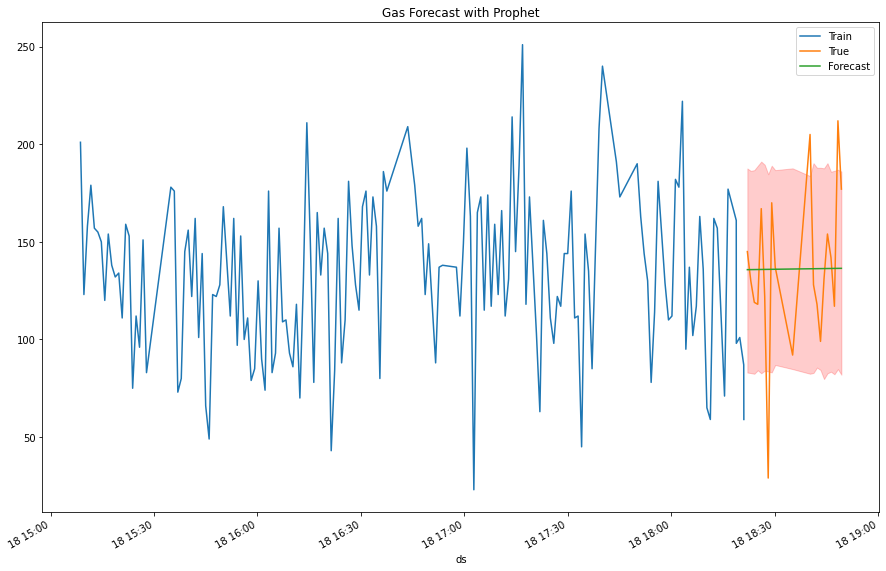

In [27]:
fig, ax = plt.subplots(figsize=(15, 10))
temporary_gas_train['y'].plot(ax=ax, label='Train')
temporary_gas_predict['y'].plot(ax=ax, label= 'True')
gas_prediction_prophet['yhat'].plot(ax=ax, label='Forecast')
ax.fill_between(
    gas_prediction_prophet.index,
    gas_prediction_prophet['yhat_lower'],
    gas_prediction_prophet['yhat_upper'],
    color = 'red',
    alpha = 0.2
)
ax.set_title('Gas Forecast with Prophet')
ax.legend();

# Forecasting with ARIMA (Autoregressive Integrated Moving Average)

In [28]:
periods_humidity_arima = 15
train_humidity, test_humidity = humidity[:-periods_humidity_arima], humidity[-periods_humidity_arima:]

In [29]:
train_humidity['time'] = pd.to_datetime(train_humidity['time'])
train_humidity = train_humidity.set_index('time')
test_humidity['time'] = pd.to_datetime(test_humidity['time'])
test_humidity = test_humidity.set_index('time')

C:\Users\Marco\AppData\Local\Temp\ipykernel_8576\435547034.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_humidity['time'] = pd.to_datetime(train_humidity['time'])
C:\Users\Marco\AppData\Local\Temp\ipykernel_8576\435547034.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_humidity['time'] = pd.to_datetime(test_humidity['time'])


#### Dickey-Fuller test to determine whether the data is stationary or not

In [30]:
from statsmodels.tsa.stattools import adfuller

adfuller_result_humidity = adfuller(train_humidity)
adfuller_result_humidity[1]

0.9464458890090935

Time-Series is not stationary, therefore we procede with first order differencing and thus determining the parameter <em>(d)</em>

In [31]:
new_train_humidity = train_humidity.diff().dropna()
adfuller_result_humidity = adfuller(new_train_humidity)
adfuller_result_humidity[1]

6.74082465172751e-25

With first differentiation the <em>value</em> drops below the significance level of **0.05** and therefore the <em>d-value</em> for **Humidity** will be set to **1**

The next steps are computing <em>p-value</em> <em>q-value</em> which represent respectively the order of the autoregressive term of the model and the order of the moving average term.

The first refers to the number of lags to be used as predictors, while the latter to the number of lagged forecast errors that should go into the ARIMA model

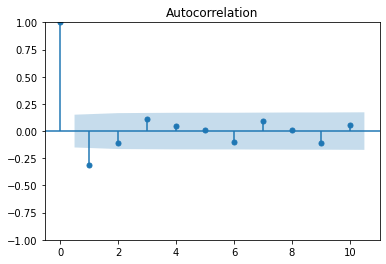

In [32]:
from statsmodels.graphics import tsaplots

figure = tsaplots.plot_acf(new_train_humidity, lags=10)
plt.show()

The first lag shows to be the most significant, therefore we set <em>p-value</em> to **1**

c:\Users\Marco\miniconda3\envs\InternetOfThings\lib\site-packages\statsmodels\graphics\tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


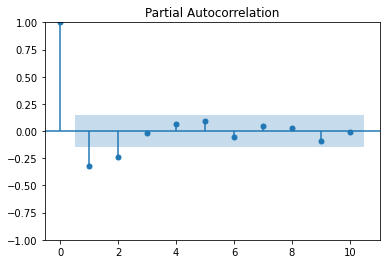

In [33]:
figure = tsaplots.plot_pacf(new_train_humidity, lags=10)
plt.show()

Also in this case the first lag show most significance, also  <em>q-value</em> will be **1**

We can now apply the **ARIMA** model

In [34]:
history = [x for x in train_humidity['humidity']]
predictions_humidity_arima = pd.DataFrame(columns=['yhat', 'lower', 'upper'])

for t in test_humidity.index:
    model = ARIMA(history, order=(1,1,1))
    model_fit = model.fit()
    # forecasts only one sample
    out = model_fit.get_forecast()
    conf = out.conf_int(alpha=0.05)
    predictions_humidity_arima.loc[len(predictions_humidity_arima)] = [out.predicted_mean[0], conf[0][0], conf[0][1]]
    obs = test_humidity.loc[t][0]
    history.append(obs)

In [35]:
predictions_humidity_arima['time'] = test_humidity.index
predictions_humidity_arima['time'] = pd.to_datetime(predictions_humidity_arima['time'])
predictions_humidity_arima = predictions_humidity_arima.set_index('time')

In [36]:
mse = compute_MSE(test_humidity.values, predictions_humidity_arima['yhat'].values)
mse

0.3334786249836899

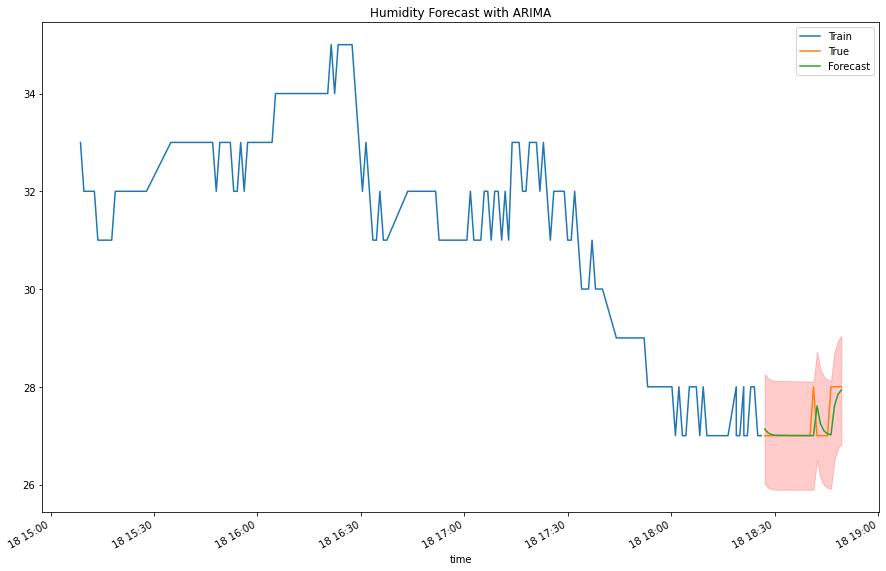

In [37]:
fig, ax = plt.subplots(figsize=(15, 10))
train_humidity['humidity'].plot(ax=ax, label='Train')
test_humidity['humidity'].plot(ax=ax, label= 'True')
predictions_humidity_arima['yhat'].plot(ax=ax, label='Forecast')
ax.fill_between(
    predictions_humidity_arima.index,
    predictions_humidity_arima['lower'],
    predictions_humidity_arima['upper'],
    color = 'red',
    alpha = 0.2
)
ax.set_title('Humidity Forecast with ARIMA')
ax.legend();

Let's apply the same steps for the other two time-series: **Temperature** and **Gas**

Let's get down with temperature first:

In [38]:
periods_temperature_arima = 15
train_temperature, test_temperature = temperature[:-periods_temperature_arima], temperature[-periods_temperature_arima:]



In [39]:
train_temperature['time'] = pd.to_datetime(train_temperature['time'])
train_temperature = train_temperature.set_index('time')
test_temperature['time'] = pd.to_datetime(test_temperature['time'])
test_temperature = test_temperature.set_index('time')

C:\Users\Marco\AppData\Local\Temp\ipykernel_8576\628247281.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_temperature['time'] = pd.to_datetime(train_temperature['time'])
C:\Users\Marco\AppData\Local\Temp\ipykernel_8576\628247281.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_temperature['time'] = pd.to_datetime(test_temperature['time'])


In [40]:
adfuller_result_temperature = adfuller(train_temperature)
adfuller_result_temperature[1]

0.05730473461718261

In [41]:
new_train_temperature = train_temperature.diff().dropna()
adfuller_result_temperature = adfuller(new_train_temperature)
adfuller_result_temperature[1]

1.5963807930763926e-18

<em>d-value</em> for **Temperature** will be set to **1**

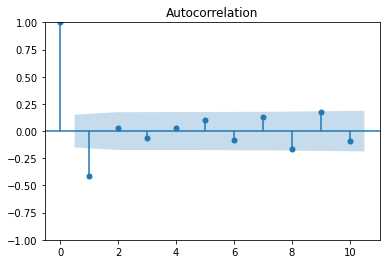

In [42]:
figure = tsaplots.plot_acf(new_train_temperature, lags=10)
plt.show()

<em>p-value</em> = 1

c:\Users\Marco\miniconda3\envs\InternetOfThings\lib\site-packages\statsmodels\graphics\tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


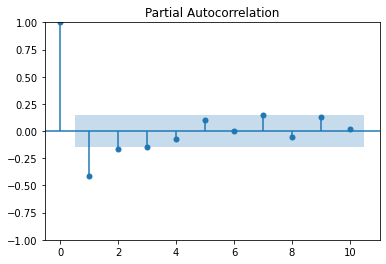

In [43]:
figure = tsaplots.plot_pacf(new_train_temperature, lags=10)
plt.show()

<em>q-value</em> = **1**

In [44]:
history = [x for x in train_temperature['temperature']]
predictions_temperature_arima = pd.DataFrame(columns=['yhat', 'lower', 'upper'])

for t in test_temperature.index:
    model = ARIMA(history, order=(1,1,1))
    model_fit = model.fit()
    # forecasts only one sample
    out = model_fit.get_forecast()
    conf = out.conf_int(alpha=0.05)
    predictions_temperature_arima.loc[len(predictions_temperature_arima)] = [out.predicted_mean[0], conf[0][0], conf[0][1]]
    obs = test_temperature.loc[t][0]
    history.append(obs)

In [45]:
predictions_temperature_arima['time'] = test_temperature.index
predictions_temperature_arima['time'] = pd.to_datetime(predictions_temperature_arima['time'])
predictions_temperature_arima = predictions_temperature_arima.set_index('time')

In [46]:
mse = compute_MSE(test_temperature.values, predictions_temperature_arima['yhat'].values)
mse

0.048772886889486625

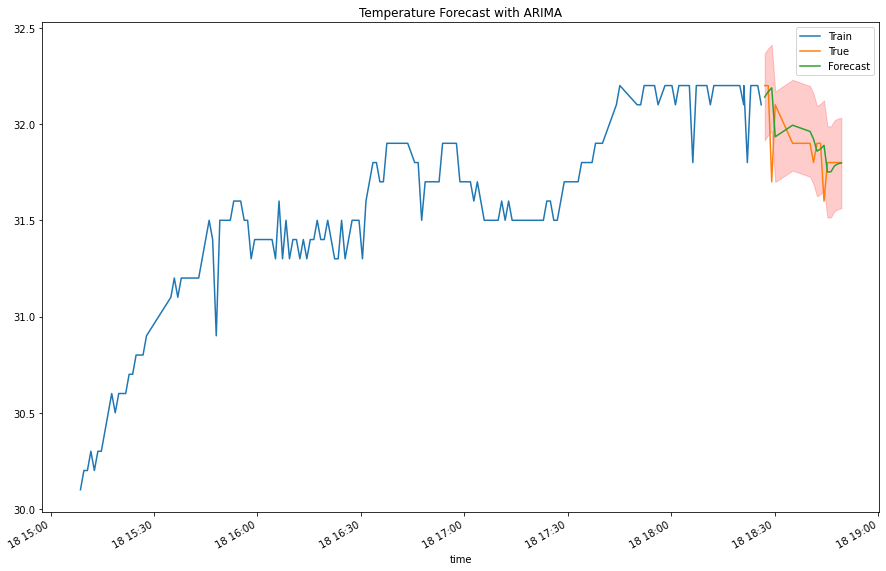

In [47]:
fig, ax = plt.subplots(figsize=(15, 10))
train_temperature['temperature'].plot(ax=ax, label='Train')
test_temperature['temperature'].plot(ax=ax, label= 'True')
predictions_temperature_arima['yhat'].plot(ax=ax, label='Forecast')
ax.fill_between(
    predictions_temperature_arima.index,
    predictions_temperature_arima['lower'],
    predictions_temperature_arima['upper'],
    color = 'red',
    alpha = 0.2
)
ax.set_title('Temperature Forecast with ARIMA')
ax.legend();

Gas time-series will be the next

In [48]:
periods_gas_arima = 15
train_gas, test_gas = gas[:-periods_gas_arima], gas[-periods_gas_arima:]

In [49]:
train_gas['time'] = pd.to_datetime(train_gas['time'])
train_gas = train_gas.set_index('time')
test_gas['time'] = pd.to_datetime(test_gas['time'])
test_gas = test_gas.set_index('time')

C:\Users\Marco\AppData\Local\Temp\ipykernel_8576\685445946.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_gas['time'] = pd.to_datetime(train_gas['time'])
C:\Users\Marco\AppData\Local\Temp\ipykernel_8576\685445946.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_gas['time'] = pd.to_datetime(test_gas['time'])


In [50]:
adfuller_result_gas = adfuller(train_gas)
adfuller_result_gas[1]

2.1599894218558577e-07

Gas time-series Dickey-Fuller test seems right without differentiation, therefore <em>d-value</em> will be set to **0**

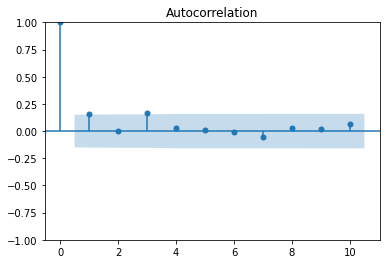

In [51]:
figure = tsaplots.plot_acf(train_gas, lags=10)
plt.show()

<em>p-value</em> = **1**

c:\Users\Marco\miniconda3\envs\InternetOfThings\lib\site-packages\statsmodels\graphics\tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


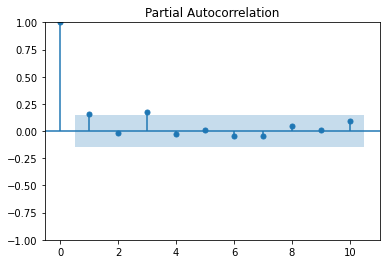

In [52]:
figure = tsaplots.plot_pacf(train_gas, lags=10)
plt.show()

<em>q-value</em> = **1**

In [53]:
history = [x for x in train_gas['gas']]
predictions_gas_arima = pd.DataFrame(columns=['yhat', 'lower', 'upper'])

for t in test_gas.index:
    model = ARIMA(history, order=(0,1,1))
    model_fit = model.fit()
    # forecasts only one sample
    out = model_fit.get_forecast()
    conf = out.conf_int(alpha=0.05)
    predictions_gas_arima.loc[len(predictions_gas_arima)] = [out.predicted_mean[0], conf[0][0], conf[0][1]]
    obs = test_gas.loc[t][0]
    history.append(obs)

In [54]:
predictions_gas_arima['time'] = test_gas.index
predictions_gas_arima['time'] = pd.to_datetime(predictions_gas_arima['time'])
predictions_gas_arima = predictions_gas_arima.set_index('time')

In [55]:
mse = compute_MSE(test_gas.values, predictions_gas_arima['yhat'].values)
mse

2067.8798295563925

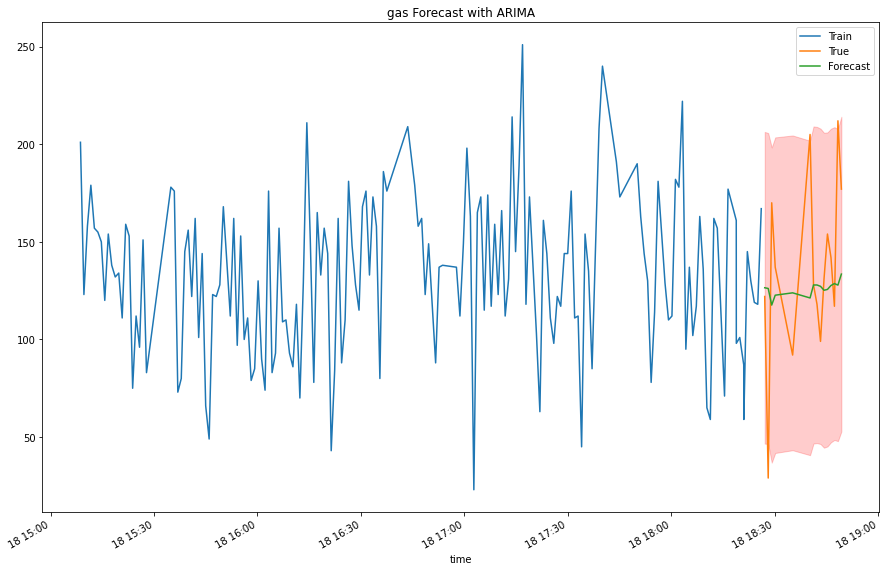

In [56]:
fig, ax = plt.subplots(figsize=(15, 10))
train_gas['gas'].plot(ax=ax, label='Train')
test_gas['gas'].plot(ax=ax, label= 'True')
predictions_gas_arima['yhat'].plot(ax=ax, label='Forecast')
ax.fill_between(
    predictions_gas_arima.index,
    predictions_gas_arima['lower'],
    predictions_gas_arima['upper'],
    color = 'red',
    alpha = 0.2
)
ax.set_title('gas Forecast with ARIMA')
ax.legend();

# Prediction with Sklearn's RandomForestRegressor

In [60]:
from sklearn.ensemble import RandomForestRegressor
from skforecast.ForecasterAutoreg import ForecasterAutoreg
from skforecast.model_selection import grid_search_forecaster

In [ ]:
# Hyperparameter Grid search
# ==============================================================================
import warnings
warnings.filterwarnings("ignore")
# steps = len(data_test_gas)           #dataset's length
forecaster = ForecasterAutoreg(
                regressor = RandomForestRegressor(random_state=123),
                lags      = 3 # This value will be replaced in the grid search
             )

# Lags used as predictors
lags_grid = [30,40,50]

# Regressor's hyperparameters
param_grid = {'n_estimators': [100, 200, 300],
              'max_depth': [10, 15, 20]}

results_grid = grid_search_forecaster(
                        forecaster         = forecaster,
                        # y                  = data_train_gas['gas'],        #Here we need to insert the train dataset
                        param_grid         = param_grid,
                        lags_grid          = lags_grid,
                        steps              = steps,
                        refit              = True,
                        metric             = 'mean_squared_error',
                        initial_train_size = int(len(data_train_gas) * 0.8),
                        fixed_train_size   = False,
                        return_best        = True,
                        verbose            = False
               )

In [61]:
temporary_temperature = temperature.copy()
temporary_temperature = temporary_temperature.drop_duplicates()

temporary_temperature['time'] = pd.to_datetime(temporary_temperature['time'])
temporary_temperature = temporary_temperature.set_index('time')

In [66]:
periods_temperature = 19 #Dimension of test set and therefore periods that are going to be predicted
data_train_temperature = temporary_temperature[:-periods_temperature]
data_test_temperature = temporary_temperature[-periods_temperature:]

print(f"Train dates : {data_train_temperature.index.min()} --- {data_train_temperature.index.max()}  (n={len(data_train_temperature)})")
print(f"Test dates  : {data_test_temperature.index.min()} --- {data_test_temperature.index.max()}  (n={len(data_test_temperature)})")

Train dates : 2022-07-18 15:08:41 --- 2022-07-18 18:22:05  (n=166)
Test dates  : 2022-07-18 18:23:05 --- 2022-07-18 18:49:21  (n=19)


In [63]:
forecaster_temperature = ForecasterAutoreg(
                regressor = RandomForestRegressor(random_state=123, max_depth=15, n_estimators=100),
                lags = 30,
                )

forecaster_temperature.fit(y=data_train_temperature['temperature'])


C:\Users\Marco\AppData\Roaming\Python\Python310\site-packages\skforecast\utils\utils.py:246: UserWarning: `y` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  warnings.warn(
C:\Users\Marco\AppData\Roaming\Python\Python310\site-packages\skforecast\utils\utils.py:246: UserWarning: `y` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  warnings.warn(


In [64]:

predictions_temperature = pd.DataFrame(forecaster_temperature.predict_interval(steps=len(data_test_temperature), interval=[1,99]))

predictions_temperature = predictions_temperature.set_index(data_test_temperature.index)

MSE value:  0.03775647081928319


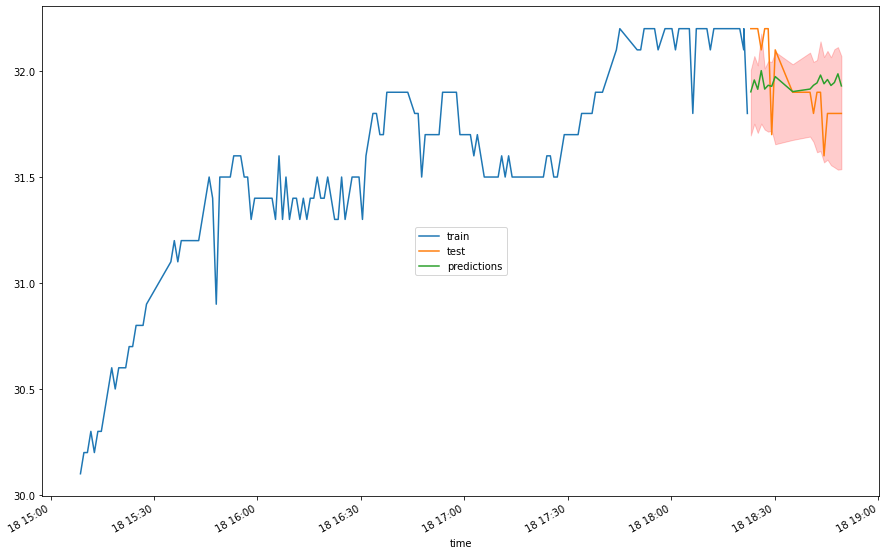

In [65]:
fig, ax = plt.subplots(figsize=(15, 10))
data_train_temperature['temperature'].plot(ax=ax, label='train')
data_test_temperature['temperature'].plot(ax=ax, label='test')
predictions_temperature['pred'].plot(ax=ax, label='predictions')
ax.fill_between(
    predictions_temperature.index,
    predictions_temperature['lower_bound'],
    predictions_temperature['upper_bound'],
    color = 'red',
    alpha = 0.2
)
ax.legend(loc='center')

print("MSE value: ", compute_MSE(data_test_temperature['temperature'], predictions_temperature['pred']))

In [68]:
temporary_humidity = humidity.copy()
temporary_humidity = temporary_humidity.drop_duplicates()

temporary_humidity['time'] = pd.to_datetime(temporary_humidity['time'])
temporary_humidity = temporary_humidity.set_index('time')

In [76]:
periods = 19 #Periods that are used in test set and therefore predicted
data_train_humidity = temporary_humidity[:-periods]
data_test_humidity  = temporary_humidity[-periods:]

print(f"Train dates : {data_train_humidity.index.min()} --- {data_train_humidity.index.max()}  (n={len(data_train_humidity)})")
print(f"Test dates  : {data_test_humidity.index.min()} --- {data_test_humidity.index.max()}  (n={len(data_test_humidity)})")

Train dates : 2022-07-18 15:08:41 --- 2022-07-18 18:22:05  (n=166)
Test dates  : 2022-07-18 18:23:05 --- 2022-07-18 18:49:21  (n=19)


In [71]:
forecaster_humidity = ForecasterAutoreg(
                regressor = RandomForestRegressor(random_state=123, max_depth=20, n_estimators=100),
                lags = 50,
                
                )

forecaster_humidity.fit(y=data_train_humidity['humidity'])

C:\Users\Marco\AppData\Roaming\Python\Python310\site-packages\skforecast\utils\utils.py:246: UserWarning: `y` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  warnings.warn(
C:\Users\Marco\AppData\Roaming\Python\Python310\site-packages\skforecast\utils\utils.py:246: UserWarning: `y` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  warnings.warn(


In [72]:

predictions_humidity = pd.DataFrame(forecaster_humidity.predict_interval(steps=len(data_test_humidity), interval=[1,99]))

predictions_humidity = predictions_humidity.set_index(data_test_humidity.index)

MSE value:  0.2538368421052629


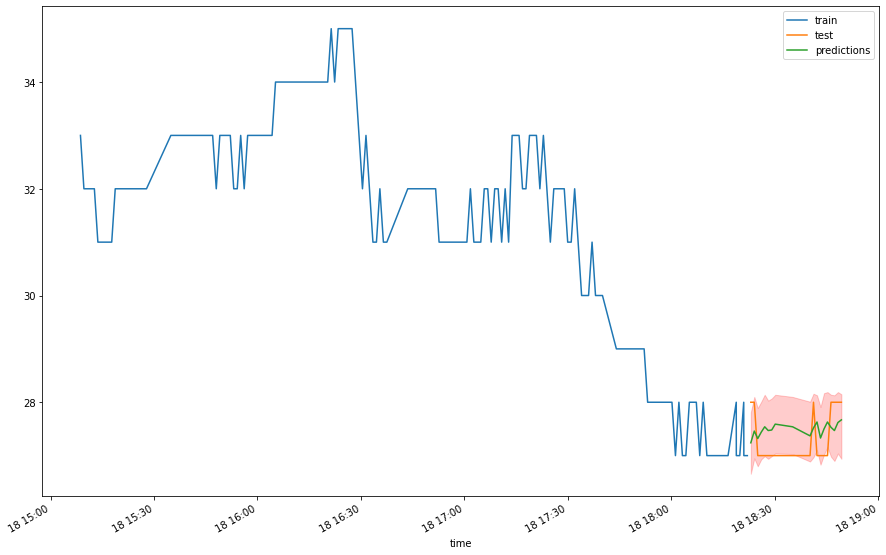

In [73]:
fig, ax = plt.subplots(figsize=(15, 10))
data_train_humidity['humidity'].plot(ax=ax, label='train')
data_test_humidity['humidity'].plot(ax=ax, label='test')
predictions_humidity['pred'].plot(ax=ax, label='predictions')
ax.fill_between(
    predictions_humidity.index,
    predictions_humidity['lower_bound'],
    predictions_humidity['upper_bound'],
    color = 'red',
    alpha = 0.2
)
ax.legend();
print("MSE value: ", compute_MSE(data_test_humidity['humidity'], predictions_humidity['pred']))

In [74]:
temporary_gas = gas.copy()
temporary_gas = temporary_gas.drop_duplicates()

temporary_gas['time'] = pd.to_datetime(temporary_gas['time'])
temporary_gas = temporary_gas.set_index('time')

In [77]:
periods_gas = 19
data_train_gas = temporary_gas[:-periods_gas]
data_test_gas  = temporary_gas[-periods_gas:]

print(f"Train dates : {data_train_gas.index.min()} --- {data_train_gas.index.max()}  (n={len(data_train_gas)})")
print(f"Test dates  : {data_test_gas.index.min()} --- {data_test_gas.index.max()}  (n={len(data_test_gas)})")


Train dates : 2022-07-18 15:08:41 --- 2022-07-18 18:22:05  (n=166)
Test dates  : 2022-07-18 18:23:05 --- 2022-07-18 18:49:21  (n=19)


In [79]:

forecaster_gas = ForecasterAutoreg(
                regressor = RandomForestRegressor(random_state=123, max_depth=20, n_estimators=200),
                lags = 50,
                
                )

forecaster_gas.fit(y=data_train_gas['gas'])

C:\Users\Marco\AppData\Roaming\Python\Python310\site-packages\skforecast\utils\utils.py:246: UserWarning: `y` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  warnings.warn(
C:\Users\Marco\AppData\Roaming\Python\Python310\site-packages\skforecast\utils\utils.py:246: UserWarning: `y` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  warnings.warn(


In [80]:
predictions_gas = pd.DataFrame(forecaster_gas.predict_interval(steps=len(data_test_gas), interval=[1,99]))

predictions_gas= predictions_gas.set_index(data_test_gas.index)

MSE value:  1781.191082894737


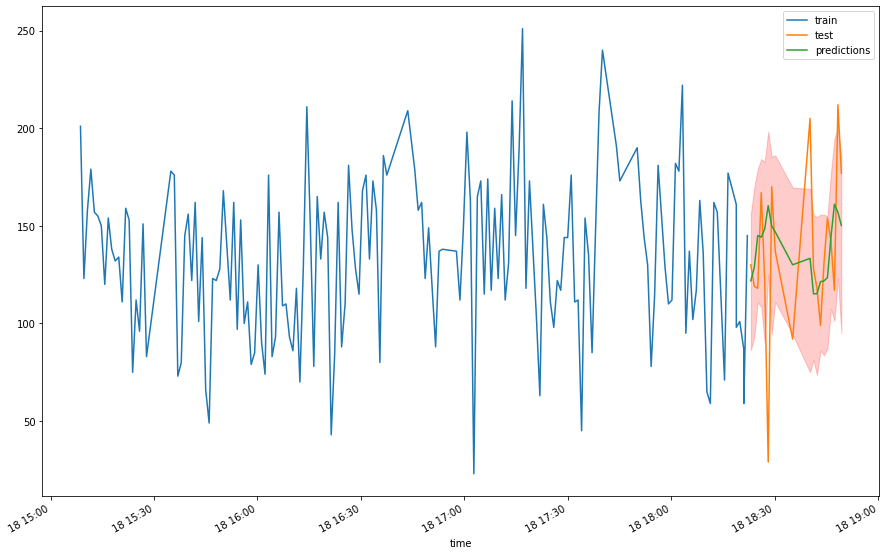

In [81]:

fig, ax = plt.subplots(figsize=(15, 10))
data_train_gas['gas'].plot(ax=ax, label='train')
data_test_gas['gas'].plot(ax=ax, label='test')
predictions_gas['pred'].plot(ax=ax, label='predictions')
ax.fill_between(
    predictions_gas.index,
    predictions_gas['lower_bound'],
    predictions_gas['upper_bound'],
    color = 'red',
    alpha = 0.2
)
ax.legend();

print("MSE value: ", compute_MSE(data_test_gas['gas'], predictions_gas['pred']))

# Sending predicted values to InfluxDB

## Sending Prophet predictions

In [151]:
from to_influx import send_predicted_values
measurement = "Weather"
tags = [("GPS", "44.49-11.313"), ("ID", "1")]

key_temperature = 'predicted_temperature_prophet'
key_gas = 'predicted_gas_prophet'
key_humidity = 'predicted_humidity_prophet'

temp = temperature_prediction_prophet['yhat'].values
times = temperature_prediction_prophet.index

hum = humidity_prediction_prophet['yhat'].values
times_hum = humidity_prediction_prophet.index

gas_pred = gas_prediction_prophet['yhat'].values
times_gas = gas_prediction_prophet.index

In [152]:
send_predicted_values(measurement=measurement, tags=tags, key= key_temperature, values=temp, times=times)

send_predicted_values(measurement=measurement, tags=tags, key= key_gas, values=gas_pred, times=times_gas)

send_predicted_values(measurement=measurement, tags=tags, key= key_humidity, values=hum, times=times_hum)

## Sending ARIMA predictions

In [166]:
key_temperature_ar = 'predicted_temperature_arima'
key_gas_ar = 'predicted_gas_arima'
key_humidity_ar = 'predicted_humidity_arima'

In [167]:
temp_ar = predictions_temperature_arima['yhat'].values
times_temp_ar = predictions_temperature_arima.index

hum_ar = predictions_humidity_arima['yhat'].values
times_hum_ar = predictions_humidity_arima.index

gas_ar = predictions_gas_arima['yhat'].values
times_gas_ar = predictions_gas_arima.index

In [168]:
send_predicted_values(measurement=measurement, tags=tags, key= key_temperature_ar, values=temp_ar, times=times_temp_ar)
send_predicted_values(measurement=measurement, tags=tags, key= key_gas_ar, values=gas_ar, times=times_gas_ar)
send_predicted_values(measurement=measurement, tags=tags, key= key_humidity_ar, values=hum_ar, times=times_hum_ar)

## Sending SKlearn RandomForestRegressor predictions

In [178]:
key_temperature_sk = 'predicted_temperature_sk'
key_gas_sk = 'predicted_gas_sk'
key_humidity_sk = 'predicted_humidity_sk'

In [179]:
gas_sk = predictions_gas['pred'].values
times_gas_sk = predictions_gas.index

temp_sk = predictions_temperature['pred'].values
times_temp_sk = predictions_temperature.index

hum_sk = predictions_humidity['pred'].values
times_hum_sk = predictions_humidity.index

In [180]:
send_predicted_values(measurement=measurement, tags=tags, key= key_gas_sk, values=gas_sk, times=times_gas_sk)
send_predicted_values(measurement=measurement, tags=tags, key= key_temperature_sk, values=temp_sk, times=times_temp_sk)
send_predicted_values(measurement=measurement, tags=tags, key= key_humidity_sk, values=hum_sk, times=times_hum_sk)

# Retrieving hourly outside temperature from Meteostat

In [184]:
from datetime import datetime
import matplotlib.pyplot as plt
from meteostat import Point, Hourly


In [211]:
start = datetime(2022, 7, 15, 0)
end = datetime(2022, 7, 22, 23)
location = Point(44.49, 11.313)

In [212]:
hourly_data = Hourly(location, start, end)

df_hourly = hourly_data.fetch()

Uploading the Hourly Temperature Time-Series to InfluxDB

In [214]:
measurement = "Weather"
tags = [("GPS", "44.49-11.313"), ("ID", "1")]

key_meteostat= 'Meteostat Temp'

send_predicted_values(measurement=measurement, tags=tags, key=key_meteostat, values=df_hourly['temp'].values, times=df_hourly.index)

# Computing Time Analytics

Since the average delay between sending and receiving was developed after the prediction part, there is no data available regarding the data used for prediction. 
Times.csv refers about half an hour of 21/07/2022 containing when the data was received and when it was sent, therefore we can create an array containing the difference between them and calculate the mean.


In [61]:
path = os.path.join(os.getcwd(), "dataset/times.csv")
times = pd.read_csv(path, header=0)

times['received'] = pd.to_datetime(times['received'])
times['sent'] = pd.to_datetime(times['sent'])



In [62]:
times_http = times[times['protocol'] == 'HTTP']

times_mqtt = times[times['protocol'] == 'MQTT']

In [63]:
diff_http = (times_http['received'] - times_http['sent'])

diff_mqtt = (times_mqtt['received'] - times_mqtt['sent'])

In [68]:
diff_int_http = [i.total_seconds() for i in diff_http]
mean_http = np.mean(diff_int_http)

diff_int_mqtt = [i.total_seconds() for i in diff_mqtt]
mean_mqtt = np.mean(diff_int_mqtt)

In [69]:
print(mean_http)

print(mean_mqtt)

1.0925925925925926
2.1904761904761907


Since MQTT protocol interfaces also with the broker emqx.io the overall delay is more then HTTP protocol